In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_curve, auc
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from tqdm import tqdm
import os
from xgboost import XGBClassifier

## Loading saved vec

In [2]:
# loading bow vectors
X_train_bow = pickle.load(open("saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("saved_feats/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("saved_feats/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("saved_feats/tfidf_features","rb")).tolist()
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("saved_feats/w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("saved_feats/X_train_avgw2v","rb"))
X_test_avgw2v = pickle.load(open("saved_feats/X_test_avgw2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))


#tfidf-w2v
X_train_tfw2v = pickle.load(open("saved_feats/X_train_tfw2v","rb"))
X_test_tfw2v = pickle.load(open("saved_feats/X_test_tfw2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))


y_tr = np.load('saved_feats/y_train.npy',allow_pickle=True)
y_test = np.load('saved_feats/y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_tr.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (70000, 51047)
shape of X_test_bow is (30000, 51047)
shape of X_train_tfidf is (70000, 51047)
shape of X_test_tfidf is (30000, 51047)
shape of X_train_avgw2v is (70000, 50)
shape of X_test_avgw2v is (30000, 50)
shape of X_train_tfw2v is (70000, 50)
shape of X_test_tfw2v is (30000, 50)
shape of y_train is (70000,)
shape of y_test is (30000,)


In [3]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()


# XGBOOST
# XGBOOST On BagOfWords Features

[02:36:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:36:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model with best parameters :
 {'max_depth': 30, 'n_estimators': 120}


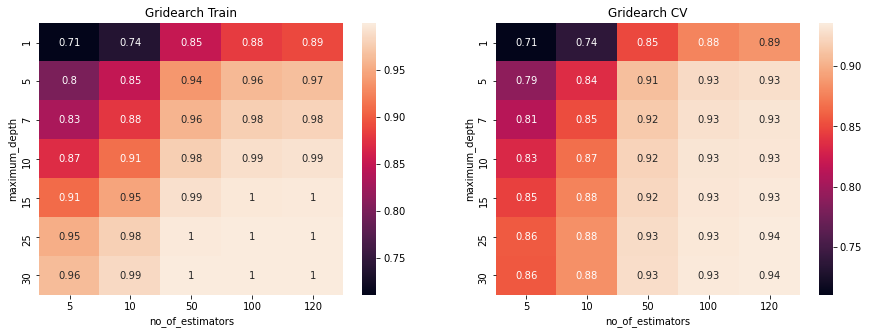

In [4]:
clf = XGBClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_bow,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("no_of_estimators")
  axes[i].set_ylabel("maximum_depth")

[02:37:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:37:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


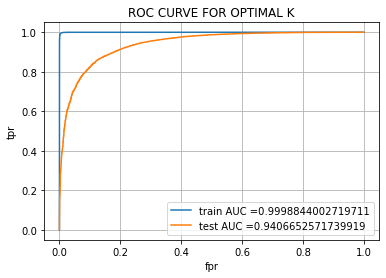

Area under train roc 0.9998844002719711
Area under test roc 0.9406652571739919


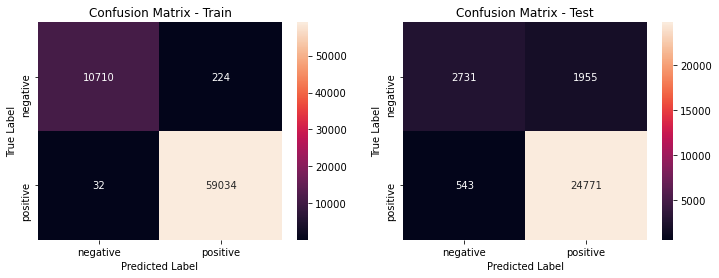

In [5]:
best_est = XGBClassifier(**model.best_params_,class_weight='balanced')
best_est = best_est.fit(X_train_bow,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_bow,y_tr,X_test_bow,y_test)

Top 20 features are: 
                    coef
perfect        0.006506
delicious      0.005361
worst          0.004658
highly         0.004530
waste          0.004444
excellent      0.004020
return         0.003688
loves          0.003607
threw          0.003421
wonderful      0.003333
refund         0.003180
horrible       0.003114
awful          0.003018
disappointing  0.002897
glad           0.002879
easy           0.002735
yummy          0.002718
pleased        0.002618
favorite       0.002614
best           0.002605


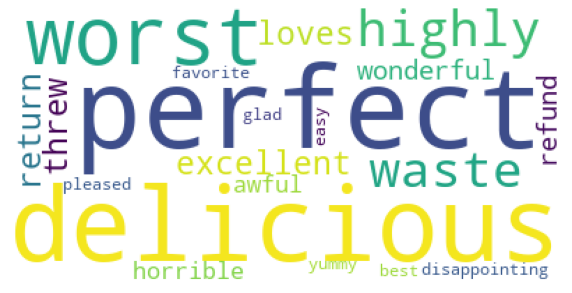

In [6]:
from wordcloud import WordCloud
dataf = best_est.feature_importances_
features = bow_features
dataf = pd.DataFrame(dataf,columns=['coef'],index=features)
top = dataf.sort_values(by='coef',ascending=False).head(20)
print('Top 20 features are: \n {}'.format(top))
top['words'] = top.index
top.reset_index(drop=True)
sent = top.words.str.cat(sep=' ')
#word cloud representation
wordcloud = WordCloud(background_color='white').generate(sent)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# XGBoost On TFIDF Features

[03:00:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:00:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model with best parameters :
 {'max_depth': 25, 'n_estimators': 120}


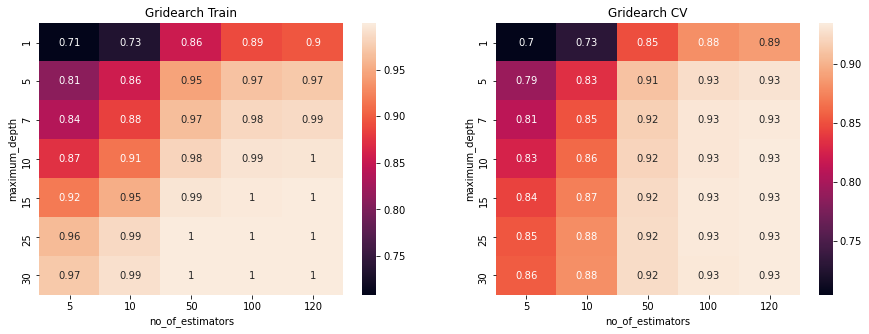

In [7]:
clf = XGBClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_tfidf,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("no_of_estimators")
  axes[i].set_ylabel("maximum_depth")

[03:01:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:01:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


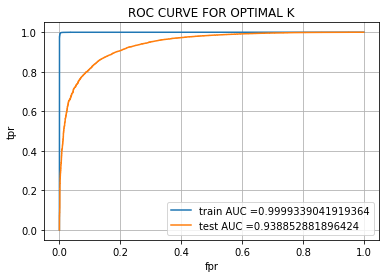

Area under train roc 0.9999339041919364
Area under test roc 0.938852881896424


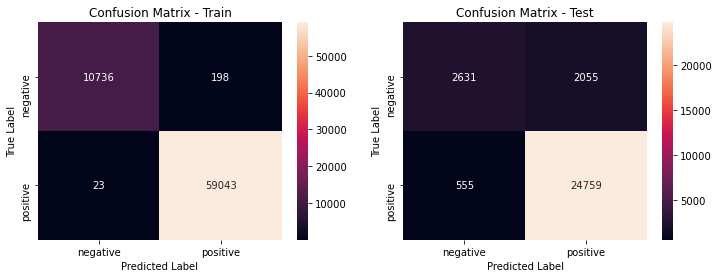

In [8]:
best_est = XGBClassifier(**model.best_params_,class_weight='balanced')
best_est = best_est.fit(X_train_tfidf,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_tfidf,y_tr,X_test_tfidf,y_test)

Top 20 features are: 
                    coef
worst          0.006218
return         0.005080
perfect        0.004872
refund         0.004707
awful          0.003954
waste          0.003926
horrible       0.003820
threw          0.003593
mistake        0.003330
terrible       0.003277
excellent      0.003267
highly         0.003174
disappointing  0.003157
misleading     0.003141
delicious      0.003118
yummy          0.003097
wonderful      0.003086
morning        0.002931
quick          0.002764
beat           0.002656


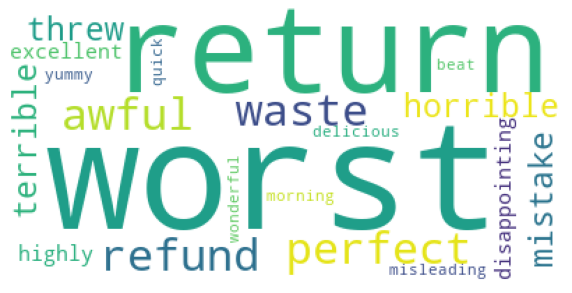

In [9]:
from wordcloud import WordCloud
dataf = best_est.feature_importances_
features = tfidf_features
dataf = pd.DataFrame(dataf,columns=['coef'],index=features)
top = dataf.sort_values(by='coef',ascending=False).head(20)
print('Top 20 features are: \n {}'.format(top))
top['words'] = top.index
top.reset_index(drop=True)
sent = top.words.str.cat(sep=' ')
#word cloud representation
wordcloud = WordCloud(background_color='white').generate(sent)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# XGBoost On AvgWord2Vec

[03:18:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:18:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model with best parameters :
 {'max_depth': 15, 'n_estimators': 120}


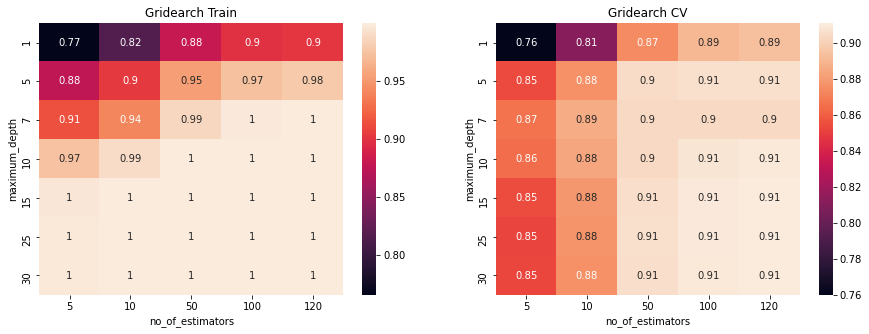

In [10]:
clf = XGBClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_avgw2v,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("no_of_estimators")
  axes[i].set_ylabel("maximum_depth")

[03:19:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:19:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


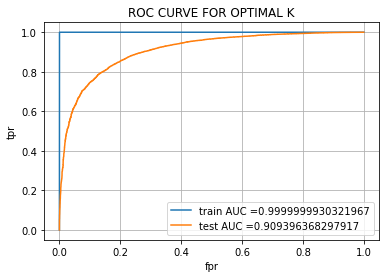

Area under train roc 0.9999999930321967
Area under test roc 0.909396368297917


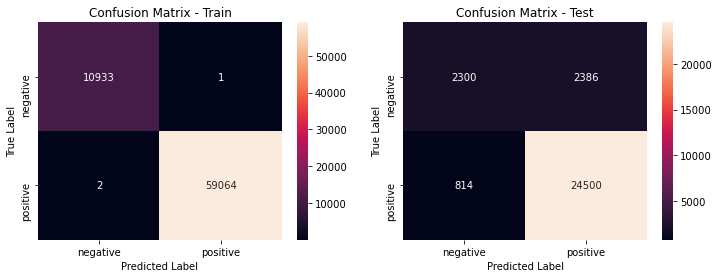

In [11]:
best_est = XGBClassifier(**model.best_params_,class_weight='balanced')
best_est = best_est.fit(X_train_avgw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_avgw2v,y_tr,X_test_avgw2v,y_test)

# XGBoost TFIDF Word2Vec

[03:32:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:32:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model with best parameters :
 {'max_depth': 15, 'n_estimators': 120}


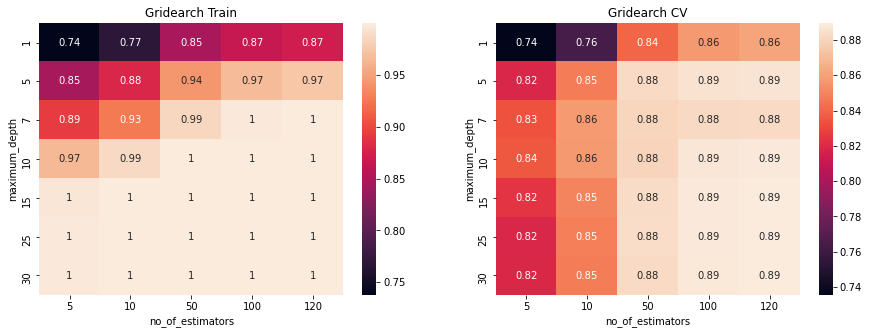

In [12]:
clf = XGBClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_tfw2v,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("no_of_estimators")
  axes[i].set_ylabel("maximum_depth")

[03:33:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:33:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


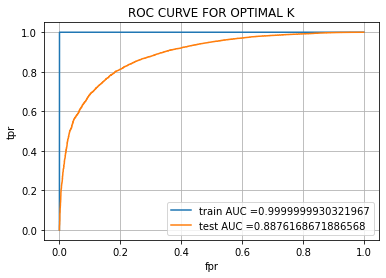

Area under train roc 0.9999999930321967
Area under test roc 0.8876168671886568


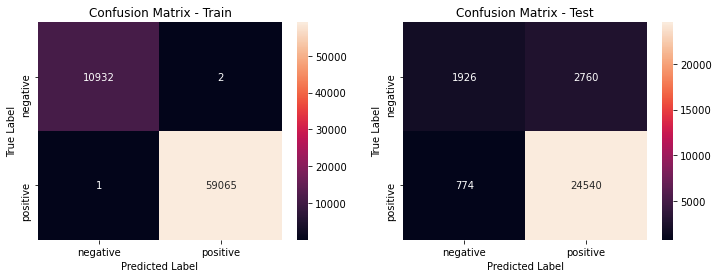

In [13]:
best_est = XGBClassifier(**model.best_params_,class_weight='balanced')
best_est = best_est.fit(X_train_tfw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_tfw2v,y_tr,X_test_tfw2v,y_test)

# Obseravations and Conclusion

In [14]:
from prettytable import PrettyTable
    
z = PrettyTable()

z.field_names = ["Vector","Algorithm","Hyperparam-no_of_estimators","Hyperparam-max_Depth","Train AUC", "Test AUC"]
z.add_row(["bow","xgboost",120,30,0.9984593917581254,0.9350458349719657])
z.add_row(["tfidf","xgboost",120,10,0.9935919563404919,0.9392664922062139])
z.add_row(["avgw2v","xgboost",120,25,0.9999999953589475, 0.9153847319440394])
z.add_row(["tfidf-w2v","xgboost",120,25,0.9999999953589473, 0.8937122710094956])
print(z)



+-----------+-----------+-----------------------------+----------------------+--------------------+--------------------+
|   Vector  | Algorithm | Hyperparam-no_of_estimators | Hyperparam-max_Depth |     Train AUC      |      Test AUC      |
+-----------+-----------+-----------------------------+----------------------+--------------------+--------------------+
|    bow    |  xgboost  |             120             |          30          | 0.9984593917581254 | 0.9350458349719657 |
|   tfidf   |  xgboost  |             120             |          10          | 0.9935919563404919 | 0.9392664922062139 |
|   avgw2v  |  xgboost  |             120             |          25          | 0.9999999953589475 | 0.9153847319440394 |
| tfidf-w2v |  xgboost  |             120             |          25          | 0.9999999953589473 | 0.8937122710094956 |
+-----------+-----------+-----------------------------+----------------------+--------------------+--------------------+
